# Train Revenue Prediction Model

This model predic the revenue of the next quarter of all B3 listed companies.

## Import Packages

In [1]:
import os
import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt

## Constants & Settings

In [2]:
DATA_SOURCE_FOLDER = "/workspaces/valuation/data/staging/numpy"
TENSORBOARD_LOG_DIR = f"/workspaces/valuation/data/staging/tensorboard/{datetime.now().strftime('%Y-%m-%d (%H:%Mh)')}"
BEST_MODEL_DESTINATION = "/workspaces/valuation/models"

# device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir=TENSORBOARD_LOG_DIR)

# Create folders
os.makedirs(BEST_MODEL_DESTINATION, exist_ok=True)

## Read Preprocessed Data

In [3]:
X_train = np.load(os.path.join(DATA_SOURCE_FOLDER, 'X_train.npy'))
y_train = np.load(os.path.join(DATA_SOURCE_FOLDER, 'y_train.npy'))
X_test = np.load(os.path.join(DATA_SOURCE_FOLDER, 'X_test.npy'))
y_test = np.load(os.path.join(DATA_SOURCE_FOLDER, 'y_test.npy'))

## Hiperparameter

In [4]:
INPUT_SIZE = X_train.shape[2]
OUTPUT_SIZE = 1
HIDDEN_SIZE = 300
NUM_LAYERS = 2
LEARNING_RATE = 0.00001
NUM_EPOCHS = 1000
BATCH_SIZE = 64
SHUFFLE_TRAIN_DATA = False
SHUFFLE_TEST_DATA = False
STOP_EARLIER_PATIENT = 10

## Define the LSTM model

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
    
    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)
        
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out


In [6]:
#class LSTMModel(nn.Module):
#    def __init__(self, input_size, hidden_size, num_layers, output_size):
#        super(LSTMModel, self).__init__()
#        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#        self.lstm2 = nn.LSTM(hidden_size, hidden_size // 2, batch_first=True)
#        self.dropout = nn.Dropout(0.2)
#        self.fc = nn.Linear(hidden_size // 2, output_size)
#
#    def forward(self, x):
#        x, _ = self.lstm1(x)
#        x, _ = self.lstm2(x)
#        x = x[:, -1, :]  # Take the output of the last time step
#        x = self.dropout(x)
#        x = self.fc(x)
#        return x

## Normalize the data

In [7]:
# Apply MinMaxScaler
#X_scaler = MinMaxScaler(feature_range=(0,1))
#y_scaler = MinMaxScaler(feature_range=(0,1))

# Apply StandardScaler
X_scaler = StandardScaler()
y_scaler = StandardScaler()

# Fit the scaler on the training data and transform both train and test data
X_train_scaled = X_scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
y_train_scaled = y_scaler.fit_transform(y_train)

X_test_scaled = X_scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_test_scaled = y_scaler.transform(y_test)

## Create dataset and dataloaders

In [8]:
X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_TRAIN_DATA)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_TEST_DATA)


## Validation function

In [9]:
def validation(model, criterion, test_loader):
    # Testing loop
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
        
        test_loss /= len(test_loader)
        return test_loss

## Prediction function

In [10]:
def predict(model, data):
    model.eval()
    data = torch.tensor(data, dtype=torch.float32)
    data = data.to(DEVICE)
    with torch.no_grad():
        outputs = model(data)
    return outputs.cpu().numpy()

## Model, loss function, optimizer

In [11]:
model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


## Trainig the Model

In [12]:
# Initialize early stopping variables
best_test_loss = float('inf')
epochs_no_improve = 0
patience = STOP_EARLIER_PATIENT  # Number of epochs to wait for improvement

In [13]:
# Training the model

print("* mark means the best model so far")

for epoch in range(NUM_EPOCHS):
    
    model.train()
    optimizer.zero_grad()
    avg_loss = 0

    for data, targets in train_loader:
        data, targets = data.to(DEVICE), targets.to(DEVICE)
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        avg_loss += loss.item() / len(train_loader)

    avg_test_loss = validation(model, criterion, test_loader)

    # Log the losses to TensorBoard
    writer.add_scalar('Loss/Train', avg_loss, epoch)
    writer.add_scalar('Loss/Test', avg_test_loss, epoch)

    # Check for early stopping
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        epochs_no_improve = 0

        # Save the best model
        torch.save(model.state_dict(), os.path.join(BEST_MODEL_DESTINATION, "best_model.pth"))
        
    else:
        epochs_no_improve += 1

    # Best model mark
    best_model_mark = "*" if epochs_no_improve==0 else ""

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Avg Train Loss: {avg_loss:.4f}, Avg Test Loss: {avg_test_loss:.4f} {best_model_mark}')
    
    if epochs_no_improve >= patience:
        print("Early stopping triggered")
        break


* mark means the best model so far
Epoch [1/1000], Avg Train Loss: 0.9880, Avg Test Loss: 1.9706 *
Epoch [2/1000], Avg Train Loss: 0.9493, Avg Test Loss: 1.8707 *
Epoch [3/1000], Avg Train Loss: 0.8706, Avg Test Loss: 1.6219 *
Epoch [4/1000], Avg Train Loss: 0.7111, Avg Test Loss: 1.3078 *
Epoch [5/1000], Avg Train Loss: 0.5845, Avg Test Loss: 1.1716 *
Epoch [6/1000], Avg Train Loss: 0.5530, Avg Test Loss: 1.1284 *
Epoch [7/1000], Avg Train Loss: 0.5364, Avg Test Loss: 1.1043 *
Epoch [8/1000], Avg Train Loss: 0.5242, Avg Test Loss: 1.0708 *
Epoch [9/1000], Avg Train Loss: 0.5094, Avg Test Loss: 1.0597 *
Epoch [10/1000], Avg Train Loss: 0.5012, Avg Test Loss: 1.0169 *
Epoch [11/1000], Avg Train Loss: 0.4823, Avg Test Loss: 1.0393 
Epoch [12/1000], Avg Train Loss: 0.4821, Avg Test Loss: 0.9453 *
Epoch [13/1000], Avg Train Loss: 0.4587, Avg Test Loss: 1.1726 
Epoch [14/1000], Avg Train Loss: 0.5168, Avg Test Loss: 0.9321 *
Epoch [15/1000], Avg Train Loss: 0.5041, Avg Test Loss: 1.0747 
Ep

## Prediction

In [34]:
# Load the best model
best_model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).to(DEVICE)
best_model.load_state_dict(torch.load(os.path.join(BEST_MODEL_DESTINATION, "best_model.pth")))

# Predict
predictions = predict(best_model, X_test)
predictions = y_scaler.inverse_transform(predictions)
actuals = y_test

## Sample

In [35]:
predictions = predictions[0:100]
actuals = actuals[0:100]

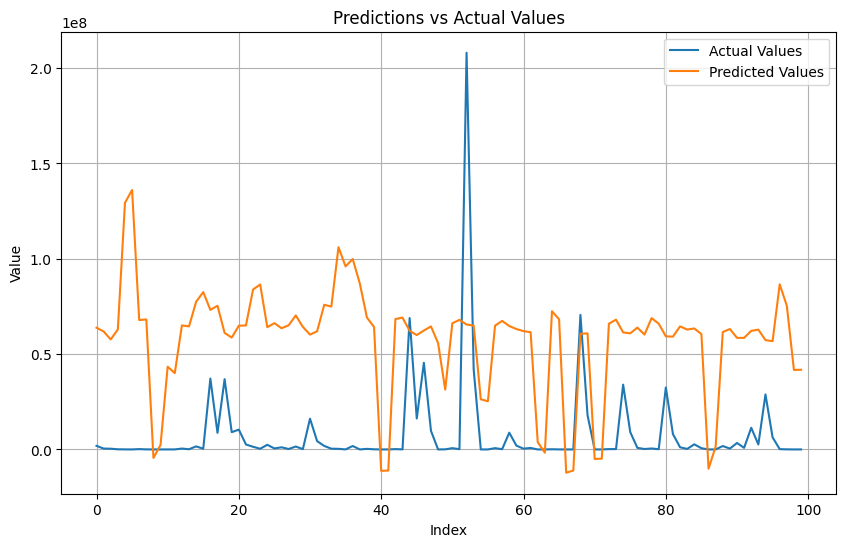

In [36]:
# Calculate the differences
differences = predictions - actuals

# Create the plot
plt.figure(figsize=(10, 6))

# Plot actual and predicted values
plt.plot(actuals, label='Actual Values')
plt.plot(predictions, label='Predicted Values')

# Plot differences
#for i in range(len(predictions)):
#    plt.plot([i, i], [predictions[i], actuals[i]], color='red', linestyle='--')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Predictions vs Actual Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()